# **Clone to github...**

# **Import**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

# **Table of contents**




1.   Part 1 - Dealing with a specific temperature
2.   Part 2 - Running on several temperatures and plotting the figure of mutual information as a function of kT
3.   Part 3 - Calculating the mutual information while using neural net (how do different temperatures effect the model?)











# **Part 1 - Calculating everything in 1 temperature**

In [ ]:
# create a list of all matrix combinations

def f_ising_creator(n, m):


  x = product([1, -1], repeat=n*m)
  x = np.reshape(list(x), (-1, n, m))


  for i in x:
    i[i==0] = -1


  lattice_combinations = x


  return lattice_combinations

In [ ]:
# split our lattices into left and right ones

def f_splitter(lattice):


  left_lattice = np.split(lattice, 2, axis=1)[0]
  right_lattice = np.split(lattice, 2, axis=1)[1]

  return left_lattice, right_lattice

In [ ]:
# calculate energy lattice of nxm lattice

def f_energy_lattice(my_lattice, n, m):

  energy_lattice = np.zeros((n,m))

  r_end = my_lattice.shape[0]-1
  c_end = my_lattice.shape[1]-1
  for i in range(n):
    for j in range(m):
      # 4 corners:
      if i == 0 and j == 0:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[0,c_end] + my_lattice[0,1] + my_lattice[1,0] + my_lattice[r_end,0]) 
      elif i == r_end and j == 0:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[r_end-1,0] + my_lattice[0,0] + my_lattice[r_end,1] + my_lattice[r_end,c_end]) 
      elif i == 0 and j == c_end:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[0,c_end-1] + my_lattice[0,0] + my_lattice[1,c_end] + my_lattice[r_end,c_end]) 
      elif i == r_end and j == c_end:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[0,0] + my_lattice[r_end,c_end-1] + my_lattice[r_end,0] + my_lattice[0,c_end]) 
      
      # first and last row:
      elif i == 0:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[0,j-1] + my_lattice[0,j+1] + my_lattice[1,j] + my_lattice[r_end,j])
        
      elif i == r_end:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[r_end,j-1] + my_lattice[r_end,j+1] + my_lattice[r_end-1,j] + my_lattice[0,j])
       
      # first and last column:
      elif j == 0:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[i,j+1] + my_lattice[i-1,j] + my_lattice[i+1,j] + my_lattice[i,c_end])
      elif j == c_end:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[i,0] + my_lattice[i,j-1] + my_lattice[i-1,j] + my_lattice[i+1,j])
      
      # regular ones:  
      else:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[i,j-1] + my_lattice[i,j+1] + my_lattice[i+1,j] + my_lattice[i-1,j]) 
      


    
  return energy_lattice

      


In [ ]:
# calculate entropy of nxm matrix

def f_entropy(energy_lattice):

  matrix = energy_lattice
  entropy = -sum(sum(np.multiply(np.exp(-matrix/kT)/(sum(sum(np.exp(-matrix/kT)))),np.log(np.exp(-matrix/kT)/(sum(sum(np.exp(-matrix/kT))))))))

  return entropy

In [ ]:
# calculate mutual information

def f_mutual_informations(S_ab, S_a, S_b):
  
  mutual_informations = (S_a + S_b) - S_ab

  return mutual_informations

In [ ]:
# calculate the averaged mutual information

def average_mutual(mutual_informations, energies_2_4):

  energy_list = []
  for i in energies_2_4:
    energy_list.append(sum(sum(i)))

  Z = sum(np.exp(-(np.array(energy_list))/kT))
  probabilities = np.exp(-np.array(energy_list)/kT)
  expected_value = (1/Z) * sum(np.multiply(mutual_informations,  probabilities))
  return expected_value 

In [ ]:
# initialize constants

kT = 3
J = 1
n = 2
m = 4

# main

ising_combinations = f_ising_creator(n, m) # list of nxm ising lattices

left_lattices = []
right_lattices = []
energies_2_4 = []
energies_2_2_left = []
energies_2_2_right = []
entropies_2_4 = []
entropies_2_2_left = []
entropies_2_2_right = []

for lattice in ising_combinations:
  energy_lattice_2_4 = f_energy_lattice(lattice, n, m) # calculate the energies of the 2x4 lattice
  energies_2_4.append(energy_lattice_2_4) # construct the list of the big lattice energies
  left_lattice, right_lattice = f_splitter(lattice) # split a lattice into left and right ones
  left_lattices.append(left_lattice) # construct the list of left lattices
  right_lattices.append(right_lattice) # construct the list of right lattices
  energy_lattice_2_2_left = f_energy_lattice(left_lattice, n, int(m/2)) # calculate the energies of the 2x2 left lattice
  energy_lattice_2_2_right = f_energy_lattice(right_lattice, n, int(m/2)) # calculate the energies of the 2x2 right lattice
  energies_2_2_left.append(energy_lattice_2_2_left) # construct the list of the small left lattice energies
  energies_2_2_right.append(energy_lattice_2_2_right) # construct the list of the small right lattice energies
  entropy_2_4 = f_entropy(energy_lattice_2_4) # calculate the entropy of the big lattice
  entropy_2_2_left = f_entropy(energy_lattice_2_2_left) # calculate the entropy of the small left lattice
  entropy_2_2_right = f_entropy(energy_lattice_2_2_right) # calculate the entropy of the small right lattice
  entropies_2_4.append(entropy_2_4) # construct the list of big lattice entropies
  entropies_2_2_left.append(entropy_2_2_left) # construct the list of the small left lattices
  entropies_2_2_right.append(entropy_2_2_right) # construct the list of the small right lattices
  mutual_informations = f_mutual_informations(np.array(entropies_2_4), np.array(entropies_2_2_left), np.array(entropies_2_2_right)) # construct the list of the mutual informations
averaged_over_all_256_mutual_informations = average_mutual(mutual_informations, energies_2_4) # calculate the averaged mutual information



### **Sanity checks**

In [ ]:
ising_combinations[21]

array([[ 1,  1,  1, -1],
       [ 1, -1,  1, -1]])

In [ ]:
left_lattices[21]

array([[ 1,  1],
       [ 1, -1]])

In [ ]:
right_lattices[21]

array([[ 1, -1],
       [ 1, -1]])

In [ ]:
energies_2_4[21]

array([[ 2.,  0.,  2.,  0.],
       [ 0., -4.,  0., -2.]])

In [ ]:
energies_2_2_left[21]

array([[ 4.,  0.],
       [ 0., -4.]])

In [ ]:
energies_2_2_right[21]

array([[ 0.,  0.],
       [ 0., -2.]])

In [ ]:
entropies_2_4[21]

1.8498517589670533

In [ ]:
entropies_2_2_left[21]

1.0242144563578832

In [ ]:
entropies_2_2_right[21]

1.3364884817358442

In [ ]:
averaged_over_all_256_mutual_informations

0.6371039438652045

In [ ]:
mutual_informations[21]

0.5108511791266741

# **Part 2 - Calculating everything in different temperatures**

In [ ]:
import numpy as np
from itertools import product

# create a list of all matrix combinations

def f_ising_creator(n, m):

  x = product([1, -1], repeat=n*m)
  x = np.reshape(list(x), (-1, n, m))
  for i in x:
    i[i==0] = -1
  lattice_combinations = x

  return lattice_combinations

# split our lattices into left and right ones

def f_splitter(lattice):

  left_lattice = np.split(lattice, 2, axis=1)[0]
  right_lattice = np.split(lattice, 2, axis=1)[1]

  return left_lattice, right_lattice

# calculate energy lattice of nxm lattice

def f_energy_lattice(my_lattice, n, m):

  energy_lattice = np.zeros((n,m))

  r_end = my_lattice.shape[0]-1
  c_end = my_lattice.shape[1]-1
  for i in range(n):
    for j in range(m):
      # 4 corners:
      if i == 0 and j == 0:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[0,c_end] + my_lattice[0,1] + my_lattice[1,0] + my_lattice[r_end,0]) 
      elif i == r_end and j == 0:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[r_end-1,0] + my_lattice[0,0] + my_lattice[r_end,1] + my_lattice[r_end,c_end]) 
      elif i == 0 and j == c_end:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[0,c_end-1] + my_lattice[0,0] + my_lattice[1,c_end] + my_lattice[r_end,c_end]) 
      elif i == r_end and j == c_end:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[0,0] + my_lattice[r_end,c_end-1] + my_lattice[r_end,0] + my_lattice[0,c_end]) 
      
      # first and last row:
      elif i == 0:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[0,j-1] + my_lattice[0,j+1] + my_lattice[1,j] + my_lattice[r_end,j])
        
      elif i == r_end:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[r_end,j-1] + my_lattice[r_end,j+1] + my_lattice[r_end-1,j] + my_lattice[0,j])
       
      # first and last column:
      elif j == 0:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[i,j+1] + my_lattice[i-1,j] + my_lattice[i+1,j] + my_lattice[i,c_end])
      elif j == c_end:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[i,0] + my_lattice[i,j-1] + my_lattice[i-1,j] + my_lattice[i+1,j])
      
      # regular ones:  
      else:
        energy_lattice[i,j] = J * my_lattice[i,j] * (my_lattice[i,j-1] + my_lattice[i,j+1] + my_lattice[i+1,j] + my_lattice[i-1,j]) 
      
  return energy_lattice

      
# calculate entropy of nxm matrix

def f_entropy(energy_lattice):

  matrix = energy_lattice
  entropy = -sum(sum(np.multiply(np.exp(-matrix/kT)/(sum(sum(np.exp(-matrix/kT)))),np.log(np.exp(-matrix/kT)/(sum(sum(np.exp(-matrix/kT))))))))

  return entropy



# calculate mutual information

def f_mutual_informations(S_ab, S_a, S_b):
  
  mutual_informations = (S_a + S_b) - S_ab

  return mutual_informations


# calculate the averaged mutual information

def average_mutual(mutual_informations, energies_2_4):

  energy_list = []
  for i in energies_2_4:
    energy_list.append(sum(sum(i)))

  Z = sum(np.exp(-(np.array(energy_list))/kT))
  probabilities = np.exp(-np.array(energy_list)/kT)
  expected_value = (1/Z) * sum(np.multiply(mutual_informations,  probabilities))
  return expected_value 

#============================ Main =======================#

# initialize constants
def main(kT, n, m):

  #kT = 3
  J = 1
  #n = 2
  #m = 4


  ising_combinations = f_ising_creator(n, m) # list of nxm ising lattices

  left_lattices = []
  right_lattices = []
  energies_2_4 = []
  energies_2_2_left = []
  energies_2_2_right = []
  entropies_2_4 = []
  entropies_2_2_left = []
  entropies_2_2_right = []

  for lattice in ising_combinations:
    energy_lattice_2_4 = f_energy_lattice(lattice, n, m) # calculate the energies of the 2x4 lattice
    energies_2_4.append(energy_lattice_2_4) # construct the list of the big lattice energies
    left_lattice, right_lattice = f_splitter(lattice) # split a lattice into left and right ones
    left_lattices.append(left_lattice) # construct the list of left lattices
    right_lattices.append(right_lattice) # construct the list of right lattices
    energy_lattice_2_2_left = f_energy_lattice(left_lattice, n, int(m/2)) # calculate the energies of the 2x2 left lattice
    energy_lattice_2_2_right = f_energy_lattice(right_lattice, n, int(m/2)) # calculate the energies of the 2x2 right lattice
    energies_2_2_left.append(energy_lattice_2_2_left) # construct the list of the small left lattice energies
    energies_2_2_right.append(energy_lattice_2_2_right) # construct the list of the small right lattice energies
    entropy_2_4 = f_entropy(energy_lattice_2_4) # calculate the entropy of the big lattice
    entropy_2_2_left = f_entropy(energy_lattice_2_2_left) # calculate the entropy of the small left lattice
    entropy_2_2_right = f_entropy(energy_lattice_2_2_right) # calculate the entropy of the small right lattice
    entropies_2_4.append(entropy_2_4) # construct the list of big lattice entropies
    entropies_2_2_left.append(entropy_2_2_left) # construct the list of the small left lattices
    entropies_2_2_right.append(entropy_2_2_right) # construct the list of the small right lattices
    mutual_informations = f_mutual_informations(np.array(entropies_2_4), np.array(entropies_2_2_left), np.array(entropies_2_2_right)) # construct the list of the mutual informations
  averaged_over_all_256_mutual_informations = average_mutual(mutual_informations, energies_2_4) # calculate the averaged mutual information


  return left_lattices, averaged_over_all_256_mutual_informations




In [ ]:
list_left_lattices = []
list_mutual_information = []
start_kT = 0.01
end_kT = 4
num_T = 100

n= 2
m = 4

for kT in np.linspace(start_kT, end_kT, num=num_T, endpoint=False):

  left_lattices, averaged_mutual_information = main(kT, n, m)
  list_left_lattices.append(left_lattices)
  list_mutual_information.append(averaged_mutual_information)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in exp


Text(0.5, 0, 'kT')

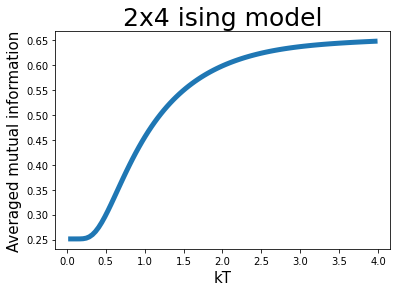

In [ ]:
plt.plot(np.linspace(start_kT, end_kT, num=num_T, endpoint=False), list_mutual_information, linewidth=5)
plt.title(f'{n}x{m} ising model',fontsize=25)
plt.ylabel('Averaged mutual information',fontsize=15)
plt.xlabel('kT', fontsize=15)

# **Part 3 - Neural Network**

In [ ]:
seed = 1234
RS = np.random.RandomState(seed)

left_lattices = np.array(left_lattices)
right_lattices = np.array(right_lattices)
right_lattices_copy = copy.deepcopy(right_lattices)
'''
A_joint = torch.tensor(left_lattices).view(int(np.power(2,n*m)),n,int(m/2), 1)
B_joint = torch.tensor(right_lattices).view(int(np.power(2,n*m)),n,int(m/2), 1)
A_product = torch.tensor(left_lattices).view(int(np.power(2,n*m)),n,int(m/2), 1)
RS.shuffle(right_lattices_copy)
B_product = torch.tensor(copy.deepcopy(right_lattices_copy)).view(int(np.power(2,n*m)),n,int(m/2), 1)
'''
A_joint = torch.tensor(left_lattices)
B_joint = torch.tensor(right_lattices)
A_product = torch.tensor(left_lattices)
RS.shuffle(right_lattices_copy)
B_product = torch.tensor(copy.deepcopy(right_lattices_copy))

# ==== AB_joint and AB_product are 256x2x4 shape ====

AB_joint = np.concatenate((A_joint, B_joint), axis=2)
AB_product = np.concatenate((A_product, B_product), axis=2)

In [ ]:
# Deep neural network
# Here I define the model as was written in the MICE article

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.conv1 = nn.Conv2d(4, 2, kernel_size=1)
      self.conv2 = nn.Conv2d(2, 1, kernel_size=1)
      self.fc1 = nn.Linear(2, 1)


    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      x = torch.flatten(x, 1)
      x = self.fc1(x)
      return x

In [ ]:
def MyLossFunction(f_joint, f_product):
  
  return (1/len(f_joint)) * (sum(sum(f_joint)) - sum(sum(np.log(np.exp(f_product)))))


In [ ]:
model = Net()

#PATH = './ising_net.pth'
#torch.save(model.state_dict(), PATH)
#model.load_state_dict(torch.load(PATH))

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.1)

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    MyLossFunction = MyLossFunction.cuda()
      
n_epochs = 25

# empty list to store training losses
train_losses = []

#n_epochs = 1

# training the model

# definning the tensors
AB_joint = torch.tensor(AB_joint, dtype=torch.float32)
AB_product = torch.tensor(AB_product, dtype=torch.float32)

f_joint = []
f_product = []

for epoch in range(n_epochs):

  f_joint = []
  f_product = []

  # train the model

  model.train()

  for i in range (AB_product.shape[0]):
    
    # define the new dimensions of the tensors before sending to the neural net

    f_joint.append(model(AB_joint[i].view(n, m, 1, 1)))
    f_product.append(model(AB_product[i].view(n, m, 1, 1)))

  f_joint = np.array(f_joint)
  f_product = np.array(f_product)
  
  f_joint_numpy = []
  f_product_numpy = []

  # changing the elements from torch elements into numpy elements

  for i in f_joint:
    f_joint_numpy.append(i.detach().numpy())
  for i in f_product:
    f_product_numpy.append(i.detach().numpy())

  f_joint_numpy = np.array(f_joint_numpy)
  f_product_numpy = np.array(f_product_numpy)

  
  loss_train = torch.tensor(MyLossFunction(f_joint_numpy, f_product_numpy))
  train_losses.append(loss_train)

  loss_train.requires_grad=True

  # computing the updated weights of all the model parameters

  optimizer.zero_grad()

  loss_train.backward()
  optimizer.step()


In [ ]:
train_losses

[tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True),
 tensor([0.0018], requires_grad=True)]